# Including

In [91]:
using NBInclude
using Plots
using LaTeXStrings
using SparseArrays
using DataFrames
using ProgressBars
using Interpolations
using LinearAlgebra
@nbinclude("Hofstadter Single Particle in Julia.ipynb"; regex=r"#.*executeme")
@nbinclude(joinpath("..","First Band Approximation Functions.ipynb"))
@nbinclude(joinpath("../Braiding Utils.ipynb"))
@nbinclude("../Aharonov-Bohm Phase.ipynb");

# Model Parameters

$\phi=\frac{p}{q}=\frac{p}{N_y}, N_\phi=\phi NxNy=N_x \text{ (The number of single particle degeneracy)}$

In [309]:
Nx=8
Ny=10
N=Nx*Ny
p=1
q=Ny
NPhi = Int( Nx * Ny * (p/q) )
cut_off = 8
PN = 1
U=2;

# Sub Space Kinetic Term

In [265]:
function H_sp(N, Nx, Ny, p, q)
    sp_basis = NLevelBasis(N)
    periodicity = 0 #periodic (select 1 for hard-wall conditions)
    sp_matrix = Hofstadter_SP(Nx, Ny, p/q, periodicity)
    H1 = get_sp_op(sp_basis, sp_matrix)
    return H1, sp_basis
end

H_sp (generic function with 1 method)

In [266]:
H1, sp_basis = H_sp(N, Nx, Ny, p, q);

In [267]:
function H_sub(N, Nx, Ny, p, q, H1, cut_off, sp_basis)
    sub_states = get_sub_states(H1, cut_off)
    basis_sub, P, Pt = get_projector_op(sub_states, sp_basis)
    H1_sub = get_subspace_op(H1, P, Pt)
    return H1_sub, basis_sub, P, Pt
end

H_sub (generic function with 1 method)

In [268]:
H1_sub, basis_sub, P, Pt = H_sub(N, Nx, Ny, p, q, H1, cut_off, sp_basis);

In [269]:
function H_Kin_MB(N, Nx, Ny, p, q, cut_off, PN)
    states_mb = bosonstates(basis_sub, PN) 
    basis_mb = ManyBodyBasis(basis_sub, states_mb)
    H1_MB = get_mb_op(basis_mb, H1_sub)
    return H1_MB
end

H_Kin_MB (generic function with 1 method)

In [270]:
@nbinclude("Hofstadter MB in Julia.ipynb"; regex=r"#.*executeme");

In [271]:
basis_cut_mb, basis_cut_sp = get_Bosonic_MB_Basis(cut_off, PN);

In [272]:
function H_Total_Sub(N, Nx, Ny, p, q, cut_off, PN, U, basis_cut_mb)
    H_Kin = SparseOperator(basis_cut_mb)
    H1_MB = H_Kin_MB(N, Nx, Ny, p, q, cut_off, PN)
    H_Kin.data = H1_MB.data
    H_Int = Hubbard_Interaction_op(P, Pt, basis_cut_mb, cut_off, U)
    return H_Kin, H_Kin + H_Int
end

H_Total_Sub (generic function with 1 method)

# Sub Space Hubbard Interaction Term

In [273]:
H_Kin, Total_H = H_Total_Sub(N, Nx, Ny, p, q, cut_off, PN, U, basis_cut_mb);

0.0%┣                                               ┫ 0/16 [00:00<00:00, -0s/it]
18.8%┣████████▋                                     ┫ 3/16 [00:00<00:00, 39it/s]
62.5%┣████████████████████████████▏                ┫ 10/16 [00:00<00:00, 85it/s]
100.0%┣███████████████████████████████████████████┫ 16/16 [00:00<00:00, 111it/s]
100.0%┣███████████████████████████████████████████┫ 16/16 [00:00<00:00, 111it/s]


# Total Hamiltonian with Impurity Potential

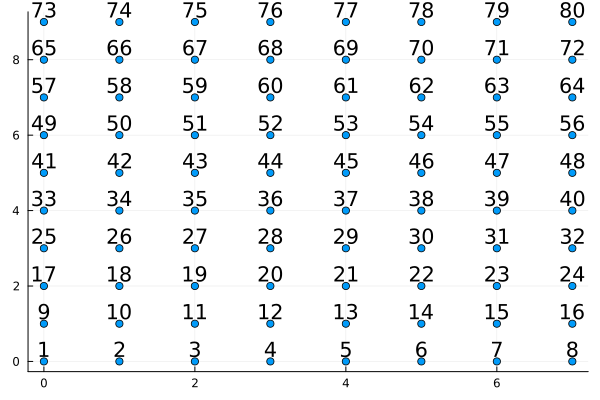

In [274]:
plot_square_lattice(Nx, Ny)

In [310]:
V0 = [-0.4]; Imp_Site = [19]
Impurity_Data = Impurity(V0, Imp_Site);

In [311]:
function Number_sub(N, sp_basis, P, Pt, basis_cut_sp, basis_cut_mb, basis_sub)
    num_sub_list = get_num_sub_list(N, sp_basis, P, Pt)
    Sub_Number_MB_Operator_List = get_num_mb_op(N, basis_cut_sp, num_sub_list, basis_cut_mb, basis_sub)
    return Sub_Number_MB_Operator_List
end

Number_sub (generic function with 1 method)

In [312]:
Sub_Number_MB_Operator_List = Number_sub(N, sp_basis, P, Pt, basis_cut_sp, basis_cut_mb, basis_sub);

0.0%┣                                               ┫ 0/80 [00:00<00:00, -0s/it]
100.0%┣█████████████████████████████████████████┫ 80/80 [00:00<00:00, 38.0kit/s]
100.0%┣█████████████████████████████████████████┫ 80/80 [00:00<00:00, 37.2kit/s]


In [313]:
function get_H_Impurity(N, sp_basis, P, Pt, basis_cut_sp, basis_cut_mb, basis_sub, Total_H, Sub_Number_MB_Operator_List, Impurity_Data)
    H_Impurity = Imp_H(Total_H, Sub_Number_MB_Operator_List, Impurity_Data)
    H_Impurity = dense((H_Impurity'+H_Impurity)/2);
    return H_Impurity
end

get_H_Impurity (generic function with 1 method)

In [314]:
H_Impurity = get_H_Impurity(N, sp_basis, P, Pt, basis_cut_sp, basis_cut_mb, basis_sub, Total_H, Sub_Number_MB_Operator_List, Impurity_Data);

In [315]:
# SP IMPURITY

In [316]:
VV   = zeros(Nx*Ny,Nx*Ny)
site = Impurity_Data.Imp_Site[1]
VV[site, site] = Impurity_Data.V0[1] # full localised single particle
VV = Operator(sp_basis,sp_basis,VV);

In [317]:
H_imp_SP = H1 + VV;

In [318]:
sub_states = get_sub_states(H_imp_SP, cut_off)
basis_sub, P, Pt = get_projector_op(sub_states, sp_basis)
H_imp_sp_sub = get_subspace_op(H_imp_SP, P, Pt)
H_imp_sp_sub = (H_imp_sp_sub' + H_imp_sp_sub)/2;

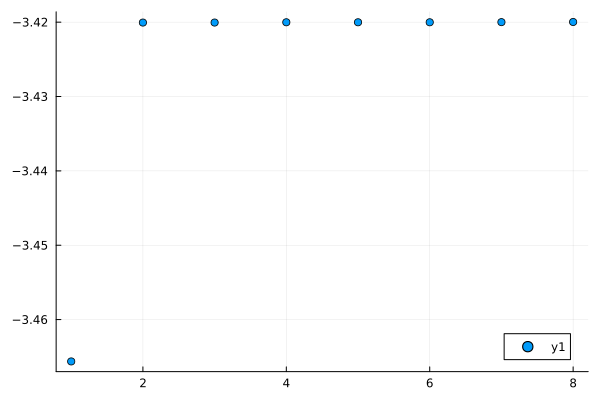

In [319]:
E_sp_sub, V_sp_sub = eigenstates(H_imp_sp_sub);
scatter(E_sp_sub)

\begin{align*}
    &\text{Filling fraction:} \quad \nu=\frac{N}{N_{\Phi}} = \frac{3}{8}, \quad \text{Laughlin fraction: } \frac{N}{N_{\Phi}}=\frac{3}{6}=\frac{1}{2} => \text{There are 2 free quasi-particles.} \\
    &\text{So, added 2 flux in the lattice is mean that, +2 free quasi-particles. One of them is pinned.}
\end{align*}

# Exact Diagonalization

In [320]:
function ground_degeneracy(N_Pin, nu0, PN)
    NPhi0 = Nx*Ny*(p/q)
    NPhi = NPhi0-N_Pin
    pn = maximum(PN)
    N_d = Int(NPhi - pn/nu0)
    Degeneracy = Int((factorial(N_d + pn - 1) / (factorial(N_d) * factorial(pn - 1))) * (NPhi / pn))
    return Degeneracy
end

ground_degeneracy (generic function with 1 method)

In [321]:
nu0 = 1/2
N_Pin = 1
Degeneracy = ground_degeneracy(N_Pin, nu0, PN)

7

In [322]:
function energies_imp(H_Impurity, PN, basis_cut_mb)
    E, V = eigenstates(H_Impurity)
    pn = maximum(PN)
    filtered_energies = get_filtered_energies(pn, E, V, basis_cut_mb)
    return E, V
end

energies_imp (generic function with 1 method)

In [323]:
PN

1

In [324]:
E, V = energies_imp(H_Impurity, PN, basis_cut_mb);

In [325]:
# Onur hocanın makalesinde ki FIG1 çıktısı

# using Plots
# using LaTeXStrings
# Plots.plot(1:35, E0, seriestype=:scatter,xlabel=L"$n$",ylabel=L"$E$",title=L"$V_{imp}=0$",legend=false)
# #ylims!((-7.20544,-7.20536))

Alltaki fonksiyonun çalışması için, dizideki filtre edilmiş parçacık sayısı her zaman en büyük değerde olmalıdır.
Örneğin, `PN=[0,1,2,3,4]` iken filtre edilen parçacık sayısı `pn=4` olmalıdır!

# Density Profile

In [326]:
filtered_energies = E
r_hubbard_states = Restricted_Hubbard_States(V);

In [159]:
function plot_density(Nx, Ny, Degeneracy, N, Sub_Number_MB_Operator_List, basis_cut_mb, r_hubbard_states, factor)
    avg_density = Get_Avg_Density(Nx, Ny, Degeneracy, N, Sub_Number_MB_Operator_List, basis_cut_mb, r_hubbard_states)
    return Plots.heatmap(Interp(avg_density', factor), aspect_ratio=:equal)
end

plot_density (generic function with 1 method)

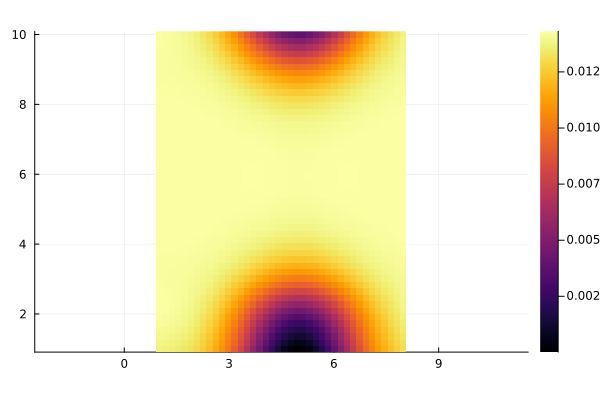

In [55]:
factor = 5
plot_density(Nx, Ny, Degeneracy, N, Sub_Number_MB_Operator_List, basis_cut_mb, r_hubbard_states, factor)
#scatter!(co[:,1].+1,co[:,2].+1, series_annotations = text.([i for i in 1:N], :bottom), legend=false)

In [160]:
plot_density(Nx, Ny, Degeneracy, N, Sub_Number_MB_Operator_List, basis_cut_mb, V_sp_sub, factor)

LoadError: MethodError: no method matching expect(::Operator{ManyBodyBasis{Vector{Int64}, NLevelBasis{Int64}, 0x22526a4a41a31c06, UInt64}, ManyBodyBasis{Vector{Int64}, NLevelBasis{Int64}, 0x22526a4a41a31c06, UInt64}, SparseMatrixCSC{ComplexF64, Int64}}, ::Ket{SubspaceBasis{Vector{Int64}, NLevelBasis{Int64}, Ket{NLevelBasis{Int64}, Vector{ComplexF64}}, 0x911b233578597cf0, UInt64}, Vector{ComplexF64}})

[0mClosest candidates are:
[0m  expect(::Operator{B1, B2, <:SparseMatrixCSC}, [91m::Operator{B2, B2}[39m) where {B1, B2}
[0m[90m   @[39m [32mQuantumOpticsBase[39m [90m~/.julia/packages/QuantumOpticsBase/PqBOl/src/[39m[90m[4moperators_sparse.jl:44[24m[39m
[0m  expect(::DataOperator{B1, B2}, [91m::DataOperator{B2, B2}[39m) where {B1, B2}
[0m[90m   @[39m [32mQuantumOpticsBase[39m [90m~/.julia/packages/QuantumOpticsBase/PqBOl/src/[39m[90m[4moperators_dense.jl:216[24m[39m
[0m  expect(::DataOperator{B, B}, [91m::Ket{B}[39m) where B
[0m[90m   @[39m [32mQuantumOpticsBase[39m [90m~/.julia/packages/QuantumOpticsBase/PqBOl/src/[39m[90m[4moperators_dense.jl:212[24m[39m
[0m  ...


# Torus Distance and Equivalent (Periodic) Sites

In [41]:
@nbinclude("Torus_Distance.ipynb");

In [42]:
coordinates, latticee = get_square_lattice(Nx, Ny)
coordinates_top_left, coordinates_top, coordinates_top_right, coordinates_left, coordinates_right, coordinates_bottom_left, coordinates_bottom, coordinates_bottom_right, co_districts = get_ghost_sites(coordinates)
ref_coordinates = coordinates
ref_site = 36 # Site Pinned (Site 44 = Site 36) # BURASI GENEL DEĞİL SORUN YARATABİLİR!!!
radius_list = get_radii(ref_coordinates, coordinates, ref_site, N);

In [43]:
All_Coordinates, X_Coordinates, Y_Coordinates, All_Coordinates_2 = get_all_sites(Nx, Ny, coordinates);

# Density Plot and $Q_{\rho}$ Calculation

In [44]:
# # Density Plot
# index_eig_states = 1
# Plots.heatmap(Get_Avg_Density(Nx, Ny, Degeneracy, N, Sub_Number_MB_Operator_List, basis_cut_mb, r_hubbard_states)', colormap=:dense)

# # koordinatları 0 yerine 1'den başlatırsak heatmap ile uyumlu olur (.+1 operasyonu)
# x_coordinates = coordinates[:,1] .+1
# y_coordinates = coordinates[:,2] .+1
# Plots.scatter!(x_coordinates, y_coordinates, label=false, aspect_ratio=1, showaxis = false, grid=false, markersize=3, c=:black, title=L"$<n_i|\Psi_1|n_i>$", xlabel=L"$x$",ylabel=L"$y$")

# # Site Index
# for i in 1:N
#     p = Plots.annotate!(x_coordinates[i],y_coordinates[i], text("$i", :Courier, 10,:green))
# end

# # Circle
# function circle_shape(h,k,r)
#     beta = reverse(LinRange(0, 2*pi, 500))
#     h .+ r*sin.(beta), k .+ r*cos.(beta)
# end

# # Bu örnekte imp_site=44 aslında 36.site'dır. Çünkü burada density en düşüktür!
# center_x = x_coordinates[36]; center_y = y_coordinates[36]; radius = 1
# Plots.plot!(circle_shape(center_x,center_y,radius), seriestype=[:shape], lw=0.5, c=:red, linecolor= :red, legend=false, fillalpha=0.2)

# p

In [45]:
# Hangi siteler, ilgili yarı-çap içerisinde, şartını kontrol ediyoruz
function Inner_Sites(Radius)
    
    ref_district = coordinates # Center Distrinct
    Ref_Site_X = ref_district[:,1][ref_site]
    Ref_Site_Y = ref_district[:,2][ref_site]
    
    inner_sites = []
    
    for i in 1:Nx*Ny*9
        
        if (X_Coordinates[i] - Ref_Site_X)^2 + (Y_Coordinates[i] - Ref_Site_Y)^2 < (Radius+0.1)^2
            
            # Yarı-çap büyüdüğünde, periyodik noktalara sıçrayınca, "get_eq_site" fonksiyonu ile eş-değer siteleri buluyoruz.
            push!(inner_sites, get_eq_site(X_Coordinates[i], Y_Coordinates[i]))
        end
    end
    
    return inner_sites
end

Inner_Sites (generic function with 1 method)

\begin{align*}
&Q_{\rho} = \sum_i \left(<n_i>_{V=0}-<n_i>_{V \neq 0} \right) \\
&\text{Isotropic (uniform) reference particle density:}<n_i>_{V=0} \\
&<n_i>_{V=0} \approx \frac{N}{(N_\phi-1)N_y} = \frac{3}{70} \\
&Q=\frac{N}{N_\phi-1}=\frac{3}{7}
\end{align*}

LoadError: UndefVarError: `x_co` not defined

In [46]:
radius_list

17-element Vector{Any}:
 0.0
 1.0
 1.4142135623730951
 2.0
 2.23606797749979
 2.8284271247461903
 3.0
 3.1622776601683795
 3.605551275463989
 4.0
 4.123105625617661
 4.242640687119285
 4.47213595499958
 5.0
 5.0990195135927845
 5.385164807134504
 5.830951894845301

In [47]:
function get_depletion_profile(radius_list, avg_density)
    
    density_list_1 = []
    density_list_2 = []
    depletion_prof = []
    
    for i in radius_list
        
        summ = 0
    
        for j in Inner_Sites(i)
            
            # r içindeki her bir sitenin ortalama yoğunluğu 
            push!(density_list_1, collect(Iterators.flatten((pn/((NPhi0-1)*Ny) .- avg_density|>transpose)))[j])
            # Örgüde sadece bir tane quasi-parçacık boştayken gelen neredeyse ortalama yoğunluk 3/70'tir!
            
            # aynı yoğunluklar gelirse sadece onların birisini tut
            density_list_2 = unique!(density_list_1)
            
            # her biri biricik ve her bir site için olan yoğunlukları topla
            summ = sum(density_list_2)
        end
        
        # Sitelerin toplam yoğunluklarını bir listede her bir yarı-çap için biriktir
        push!(depletion_prof, summ)
    end
    
    return depletion_prof
end

get_depletion_profile (generic function with 1 method)

In [48]:
depletion_prof = get_depletion_profile(radius_list, avg_density)
#Plots.plot(radius_list, depletion_prof, xlabel=L"\rho", ylabel=L"Q_{\rho}", title="Density (Charge) Depletion Profile", guidefontsize=17,legend=false, linewidth=3, xticks=0:1:12, yticks=0:0.10:0.46, m = (5, :white, stroke(1, :blue)))
# Q = pn/NPhi
# g(x)=Q; x=0
# Plots.plot!(g, x, length(radius_list), line=(:dot,2), xlim=(0,7))

17-element Vector{Any}:
 0.004301068196870227
 0.027217021017986884
 0.0561857587902977
 0.08957497216980874
 0.1692281891462068
 0.2200304439444529
 0.24954651306063208
 0.3211200397149876
 0.4130998736985483
 0.4164141016127515
 0.4267734310058875
 0.4669310201880079
 0.48231191046314775
 0.49710764475999275
 0.49710764475999275
 0.4986923508984509
 0.4999999999999996

# Berry Matrix

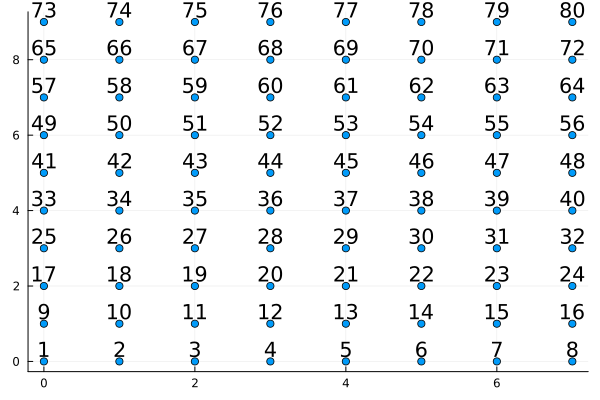

In [327]:
plot_square_lattice(Nx, Ny)

In [328]:
start_point_1 = Impurity_Data.Imp_Site[1]
#start_point_1 = 17

19

In [329]:
lens_1 = [5, 5, 5, 5]
dirs_1 = [1, -Nx, -1, Nx]
rec_path_1 = unique(rectangular_path(start_point_1,lens_1,dirs_1))
rec_path_1 = [45,46,47,48,41,34,27,26,25,24,31,38,45]
rec_path_1 = [45,46,39,38]
rec_path_1 = [51,44,37,30,23,16,17,18,25,32,39,46,53,52,51]
rec_path_1 = [19,20,21,29,37,45,53,52,51,43,35,27]

12-element Vector{Int64}:
 19
 20
 21
 29
 37
 45
 53
 52
 51
 43
 35
 27

In [330]:
#start_point_2 = Impurity_Data.Imp_Site[2]
start_point_2 = 5

5

In [331]:
lens_2 = [4, 8]
dirs_2 = [-1, Nx]
rec_path_2 = unique(rectangular_path(start_point_2,lens_2,dirs_2))
rec_path_2=rec_path_1
# i = 38
# rec_path_2 = [ 38 for i in 1:9 ]
rec_path_2 = rec_path_1

12-element Vector{Int64}:
 19
 20
 21
 29
 37
 45
 53
 52
 51
 43
 35
 27

In [332]:
N_Pin = 4
V1 = Impurity_Data.V0[1]
V2 = 0
#V2 = Impurity_Data.V0[2]

0

In [333]:
Imp_Site = [rec_path_1[1], rec_path_1[2], rec_path_2[1], rec_path_2[2]]
V0 = [V1, 0, V2, 0]
Impurity_Data = Impurity(V0, Imp_Site)

Impurity([-0.4, 0.0, 0.0, 0.0], [19, 20, 19, 20])

In [334]:
Impurity_H = Imp_H(Total_H, Sub_Number_MB_Operator_List, Impurity_Data)
Impurity_H = dense((Impurity_H+Impurity_H')/2);

In [335]:
E_Imp_0, U_Imp_0 = eigenstates(Impurity_H)
Degeneracy = 1
U_Imp_0 = hcat([U_Imp_0[i].data for i in 1:Degeneracy] ...)

16×1 Matrix{ComplexF64}:
      0.8505231921190562 - 0.5218932440975795im
    2.67841304690819e-15 - 4.111294638065033e-15im
   -7.165557907104969e-5 - 2.947075129386585e-5im
   3.191891195797325e-16 + 4.767020111984266e-15im
 -1.2857770403940094e-14 + 3.361894096443052e-15im
  -1.942890293094024e-16 + 3.3523531173251797e-16im
    3.889752752944675e-5 + 0.00013382544483169466im
   2.147587663259287e-15 + 4.3749726064135075e-15im
     -0.0564326344646397 + 0.03245019225408741im
   -2.47198095326695e-16 + 2.3245294578089215e-16im
    -5.69404291375919e-5 + 0.00015445360812037928im
  1.5543122344752192e-15 - 9.71445146547012e-17im
   5.273559366969494e-16 + 2.415602440297704e-16im
  2.0539125955565396e-15 + 3.8510861166685117e-16im
 -0.00015220066625931672 - 9.2382255684986e-5im
  1.8491369746739556e-15 + 0.0im

In [336]:
U_first = copy(U_Imp_0);

In [337]:
delta_t = 0.01
STEP = 0:delta_t:1
length(STEP)

101

In [338]:
Imp_Site_List = [ [imp, rec_path_1[idx+1], rec_path_2[idx], rec_path_2[idx+1] ] for (idx,imp) in (enumerate(rec_path_1[1:end-1])) ]
V0_List = [ [V1*(1-step), V1*step, V2*(1-step), V2*step] for step in STEP ];

In [339]:
Impurity_Data_List = [ [Impurity(V00, Imp_Sitee)] for Imp_Sitee in Imp_Site_List for V00 in V0_List ];

In [340]:
Impurity_H_List = [ Imp_H(Total_H, Sub_Number_MB_Operator_List, Impurity_Dataa[1]) for Impurity_Dataa in ProgressBar(Impurity_Data_List) ];

0.0%┣                                             ┫ 0/1.1k [00:00<00:-9, -0s/it]
100.0%┣█████████████████████████████████████┫ 1.1k/1.1k [00:00<00:00, 26.6kit/s]
100.0%┣█████████████████████████████████████┫ 1.1k/1.1k [00:00<00:00, 26.5kit/s]


In [341]:
function U_Imp_0_Ket()
    Eigen_List = []
    U_IMP_0_List = []
    for Impurity_HH in ProgressBar(Impurity_H_List)
        Impurity_HH = dense((Impurity_HH+Impurity_HH')/2)
        E_Imp, U_Imp = eigenstates(Impurity_HH)
        push!(Eigen_List, U_Imp)
        U_Imp = hcat([U_Imp[i].data for i in 1:Degeneracy] ...)
        A = U_Imp_0'*U_Imp
        A_inv = inv(A)
        U_Imp_0 = U_Imp*transpose(A_inv)
        global U_Imp_0 = gram_schmidt(U_Imp_0)
    end
    return U_Imp_0, Eigen_List, U_IMP_0_List
end

U_Imp_0_Ket (generic function with 1 method)

In [342]:
U_Imp_0, Eigen_List, U_IMP_0_List = U_Imp_0_Ket();
U_Imp_0

0.0%┣                                             ┫ 0/1.1k [00:00<00:00, -0s/it]
33.7%┣█████████████▌                          ┫ 374/1.1k [00:00<00:00, 7.4kit/s]
100.0%┣█████████████████████████████████████┫ 1.1k/1.1k [00:00<00:00, 12.1kit/s]
100.0%┣█████████████████████████████████████┫ 1.1k/1.1k [00:00<00:00, 12.1kit/s]


16×1 Matrix{ComplexF64}:
      0.7026641179768787 + 0.5077770194693282im
   -0.005229567361297195 - 0.1839835392045406im
 -0.00031282834095394495 - 0.07001819400736946im
    -0.13131469167473048 - 0.00966952309334244im
     -0.3455116252041566 + 0.23160297850361325im
   -0.012875842529469732 + 0.046934515035450784im
    -0.09732056786419957 + 0.0783023025708281im
 -1.7983193028086412e-12 + 1.0147259931194353e-11im
   -0.013862422589137138 - 0.010632195606759182im
  1.8814103625440014e-14 + 5.231231599699136e-16im
   -0.027926288943505264 + 0.0011586270210312858im
  -0.0014298326695441701 + 0.0021094801867357136im
   -0.002872602716623467 + 0.00021142405112532098im
  -0.0033620742199639907 + 0.0008648825432904122im
  -0.0002889043023564489 + 0.0019003660871927037im
  0.00040410055079442495 + 0.014216826047909787im

In [343]:
U_Imp_0 == U_first

false

In [344]:
BerryEnergies, BerryStates = eigen(U_Imp_0' * U_first)
angle.(BerryEnergies)/pi

1-element Vector{Float64}:
 -0.37437478845035577

In [68]:
# data1 = Get_Avg_Density(Nx, Ny, Degeneracy, N, Sub_Number_MB_Operator_List, basis_cut_mb, Eigen_List[1])'
# data2 = Get_Avg_Density(Nx, Ny, Degeneracy, N, Sub_Number_MB_Operator_List, basis_cut_mb, Eigen_List[185])'

In [69]:
# Plots.heatmap(Interp(data1, factor), aspect_ratio=:equal)

In [70]:
# Plots.heatmap(Interp(data2, factor), aspect_ratio=:equal)

# Single Particle Brading (coordinate)

In [92]:
co = vcat( ( [y x] for x in 0:Ny-1 for y in 0:Nx-1 ) ... );

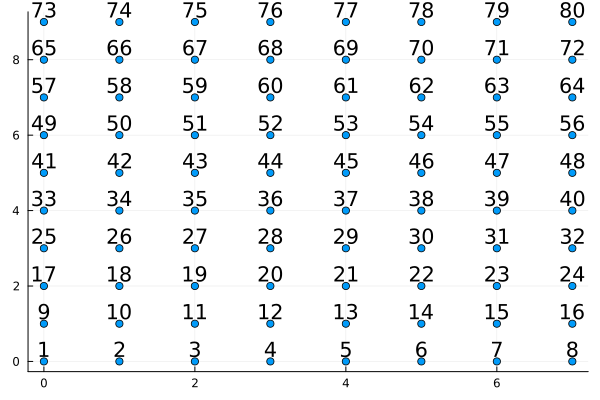

In [93]:
plot_square_lattice(Nx, Ny)

In [94]:
x0, y0 = [2,2]
x1, y1 = [4,2]
x2, y2 = [4,6]
x3, y3 = [2,6]

2-element Vector{Int64}:
 2
 6

In [95]:
U_pot = 1
Wid_pot = 10
pos = [4, 2]
imp = impurity(U_pot, pos, Wid_pot)
imp.V0

1.0

In [96]:
VV, basis_sub, P, Pt = Vpin2(imp, Nx, Ny, cut_off, sp_basis, co);

In [97]:
Total_H_sp = VV.data + H1_sub.data
Total_H_sp = (Total_H_sp' + Total_H_sp)/2;
Total_H_sp = Operator(basis_sub, basis_sub, Total_H_sp);

In [98]:
E_sp, V_sp = eigenstates(Total_H_sp)
E_sp

8-element Vector{Float64}:
 -4.4200536414081615
 -4.4101199322556095
 -4.410081591319581
 -4.410081591319576
 -4.410081591319575
 -4.400278976099622
 -4.400240625828667
 -4.400240625828665

In [99]:
num_sub_list = get_num_sub_list(N, sp_basis, P, Pt);

In [100]:
# cut_sp_basis
# number_sp_list = [Operator(basis_cut_mb, num_sub_list[i].data) for i in ProgressBar(1:N)]
# number_mb_list = [get_mb_op(basis_cut_mb, number_sp_list[i]) for i in 1:N];

In [101]:
# Sub_Number_MB_Operator_List = get_num_mb_op(N, basis_cut_sp, num_sub_list, basis_cut_mb, basis_sub);

In [102]:
function Get_DP(N, num_sub_list, V_sp, index)
    Expectation_List = []
    for site in 1:N
        push!(Expectation_List, expect(num_sub_list[site], V_sp[index]))
    end
    return real(Expectation_List)
end

Get_DP (generic function with 1 method)

In [103]:
function Get_AD(Nx, Ny, Degeneracy, N, V_sp)
    Avg_Density = spzeros(Nx,Ny)
    for index in 1:Degeneracy
        Avg_Density += reshape(Get_DP(N, num_sub_list, V_sp, index), Nx, Ny)
    end    
    return Avg_Density / Degeneracy
end

Get_AD (generic function with 1 method)

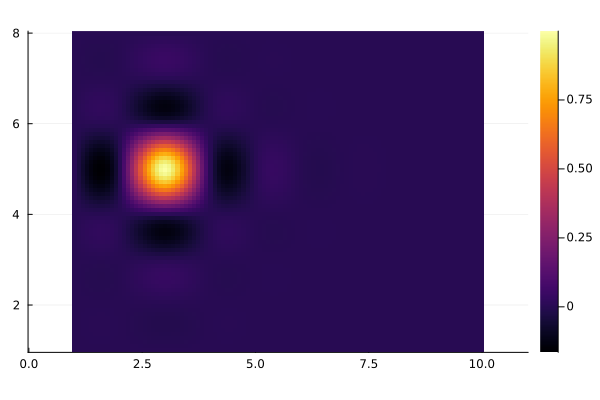

In [104]:
factor = 10
data = Get_AD(Nx, Ny, 1, N, V_sp)
Plots.heatmap(Interp(data, factor), aspect_ratio=:equal)

In [105]:
A = 1
step=0.1;

In [106]:
θ, ψ = get_ab_phase2(x0,y0,x1,y1,x2,y2,x3,y3,step,Wid_pot,U_pot,A,V_sp,Nx, Ny, cut_off,sp_basis,co,H_Kin)
θ

0.0%┣                                               ┫ 0/21 [00:00<00:00, -0s/it]
14.3%┣██████▋                                       ┫ 3/21 [00:00<00:01, 34it/s]
33.3%┣███████████████▍                              ┫ 7/21 [00:00<00:00, 52it/s]
52.4%┣███████████████████████▋                     ┫ 11/21 [00:00<00:00, 60it/s]
76.2%┣██████████████████████████████████▎          ┫ 16/21 [00:00<00:00, 65it/s]
100.0%┣████████████████████████████████████████████┫ 21/21 [00:00<00:00, 70it/s]
100.0%┣████████████████████████████████████████████┫ 21/21 [00:00<00:00, 70it/s]


4.307001131176845e-17

In [107]:
num_sub_list[1]

Operator(dim=8x8)
  basis: Subspace(superbasis=NLevel(N=80), states:8)
 0.0+0.0im  0.0+0.0im  0.0+0.0im  …  0.0+0.0im  0.0+0.0im  0.0+0.0im
 0.0+0.0im  0.0+0.0im  0.0+0.0im     0.0+0.0im  0.0+0.0im  0.0+0.0im
 0.0+0.0im  0.0+0.0im  0.0+0.0im     0.0+0.0im  0.0+0.0im  0.0+0.0im
 0.0+0.0im  0.0+0.0im  0.0+0.0im     0.0+0.0im  0.0+0.0im  0.0+0.0im
 0.0+0.0im  0.0+0.0im  0.0+0.0im     0.0+0.0im  0.0+0.0im  0.0+0.0im
 0.0+0.0im  0.0+0.0im  0.0+0.0im  …  0.0+0.0im  0.0+0.0im  0.0+0.0im
 0.0+0.0im  0.0+0.0im  0.0+0.0im     0.0+0.0im  0.0+0.0im  0.0+0.0im
 0.0+0.0im  0.0+0.0im  0.0+0.0im     0.0+0.0im  0.0+0.0im  0.0+0.0im

In [108]:
V_sp[1]

Ket(dim=8)
  basis: Subspace(superbasis=NLevel(N=80), states:8)
 0.01404850233114362 + 0.9999013149217535im
            9.36e-15 + 4.43e-15im
           -1.07e-14 + 1.427e-14im
            4.48e-15 - 7.281e-14im
          4.5473e-13 - 4.409e-14im
            6.61e-15 + 4.31e-15im
           -7.85e-15 - 7.258e-14im
           -1.81e-15 - 0.0im

In [109]:
expect(num_sub_list[1], V_sp[1])

0.0 + 0.0im

In [110]:
ψ[35][1]

Ket(dim=8)
  basis: Subspace(superbasis=NLevel(N=80), states:8)
 -0.01404850233091348 - 0.9999013149217566im
             5.23e-15 + 6.26e-15im
           1.5914e-13 + 3.295e-14im
           -4.684e-14 + 8.464e-14im
          -1.1313e-13 + 1.077e-14im
             9.14e-15 - 1.08e-15im
            4.652e-14 + 1.2114e-13im
              1.4e-15 - 0.0im

In [111]:
expect(num_sub_list[1], ψ[35][1])

LoadError: MethodError: no method matching expect(::Operator{SubspaceBasis{Vector{Int64}, NLevelBasis{Int64}, Ket{NLevelBasis{Int64}, Vector{ComplexF64}}, 0x90bc9324fa0f4cac, UInt64}, SubspaceBasis{Vector{Int64}, NLevelBasis{Int64}, Ket{NLevelBasis{Int64}, Vector{ComplexF64}}, 0x90bc9324fa0f4cac, UInt64}, Matrix{ComplexF64}}, ::Ket{SubspaceBasis{Vector{Int64}, NLevelBasis{Int64}, Ket{NLevelBasis{Int64}, Vector{ComplexF64}}, 0x61254e168fb4c3b3, UInt64}, Vector{ComplexF64}})

[0mClosest candidates are:
[0m  expect(::DataOperator{B1, B2}, [91m::DataOperator{B2, B2}[39m) where {B1, B2}
[0m[90m   @[39m [32mQuantumOpticsBase[39m [90m~/.julia/packages/QuantumOpticsBase/PqBOl/src/[39m[90m[4moperators_dense.jl:216[24m[39m
[0m  expect(::DataOperator{B, B}, [91m::Ket{B}[39m) where B
[0m[90m   @[39m [32mQuantumOpticsBase[39m [90m~/.julia/packages/QuantumOpticsBase/PqBOl/src/[39m[90m[4moperators_dense.jl:212[24m[39m
[0m  expect(::AbstractOperator, [91m::Vector[39m)
[0m[90m   @[39m [32mQuantumOpticsBase[39m [90m~/.julia/packages/QuantumOpticsBase/PqBOl/src/[39m[90m[4moperators.jl:291[24m[39m
[0m  ...


In [73]:
factor = 10
data = Get_AD(Nx, Ny, 1, N, ψ[35])
Plots.heatmap(Interp(data, factor), aspect_ratio=:equal)

LoadError: MethodError: no method matching expect(::Operator{SubspaceBasis{Vector{Int64}, NLevelBasis{Int64}, Ket{NLevelBasis{Int64}, Vector{ComplexF64}}, 0x90bc9324fa0f4cac, UInt64}, SubspaceBasis{Vector{Int64}, NLevelBasis{Int64}, Ket{NLevelBasis{Int64}, Vector{ComplexF64}}, 0x90bc9324fa0f4cac, UInt64}, Matrix{ComplexF64}}, ::Ket{SubspaceBasis{Vector{Int64}, NLevelBasis{Int64}, Ket{NLevelBasis{Int64}, Vector{ComplexF64}}, 0x61254e168fb4c3b3, UInt64}, Vector{ComplexF64}})

[0mClosest candidates are:
[0m  expect(::DataOperator{B1, B2}, [91m::DataOperator{B2, B2}[39m) where {B1, B2}
[0m[90m   @[39m [32mQuantumOpticsBase[39m [90m~/.julia/packages/QuantumOpticsBase/PqBOl/src/[39m[90m[4moperators_dense.jl:216[24m[39m
[0m  expect(::DataOperator{B, B}, [91m::Ket{B}[39m) where B
[0m[90m   @[39m [32mQuantumOpticsBase[39m [90m~/.julia/packages/QuantumOpticsBase/PqBOl/src/[39m[90m[4moperators_dense.jl:212[24m[39m
[0m  expect(::AbstractOperator, [91m::Vector[39m)
[0m[90m   @[39m [32mQuantumOpticsBase[39m [90m~/.julia/packages/QuantumOpticsBase/PqBOl/src/[39m[90m[4moperators.jl:291[24m[39m
[0m  ...


In [329]:
Get_Density_Profile(N, Sub_Number_MB_Operator_List, basis_cut_mb, ψ[30],1)

80-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 4.214021190328581e-29
 5.758008670245723e-28
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

In [321]:
Get_Avg_Density(Nx, Ny, 8, N, Sub_Number_MB_Operator_List, basis_cut_mb, ψ[1])

8×10 Matrix{Float64}:
 0.0  0.0    0.0    0.0    0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0    0.0    0.0    0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0    0.0    0.0    0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.125  0.125  0.125  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.125  0.125  0.125  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.125  0.125  0.0    0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0    0.0    0.0    0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0    0.0    0.0    0.0  0.0  0.0  0.0  0.0  0.0

In [322]:
Get_Avg_Density(Nx, Ny, 8, N, Sub_Number_MB_Operator_List, basis_cut_mb, ψ[30])

8×10 Matrix{Float64}:
 0.0  0.0    0.0    0.0    0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0    0.0    0.0    0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0    0.0    0.0    0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.125  0.125  0.125  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.125  0.125  0.125  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.125  0.125  0.0    0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0    0.0    0.0    0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0    0.0    0.0    0.0  0.0  0.0  0.0  0.0  0.0